In [ ]:
!pip install scikit-dimension
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('./drive')

Mounted at ./drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [ ]:
!cp 'drive/MyDrive/optimizer/data/R13.zip' R13.zip

In [ ]:
!unzip R13.zip

Archive:  R13.zip
  inflating: R13.txt                 


In [ ]:
!head R13.txt

4 5001 5 5 1
1 1 1 1 1
269.973387147057570 60.780472456307066 -109.243577850527500 -126.556416829193350
269.078804624365550 62.182936823000148 -118.290425725774640 -114.600930852218450
251.868777320864640 70.147627444322907 -107.550707102030370 -123.488361595036040
260.340600330471090 65.065638599131546 -103.858355638084010 -118.116241018661740
262.435524777393370 65.031025083668268 -112.798688287621490 -115.103921462297860
247.698057345374710 71.118724780537661 -99.850671539813362 -109.145354138596530
250.051593493667470 70.815188514703550 -104.338626250599060 -129.261707376946700
258.523958666769320 65.877826670239813 -102.700682291783380 -117.700272629427300


In [ ]:
with open('R13.txt') as fp:
  line = fp.readline()
  line = line.split(' ')
  d, n, m, k, p = [int(item) for item in line]
  line = fp.readline()
  line = line.split(' ')
  K = [int(item) for item in line]


In [ ]:
!tail -n +3 R13.txt > R13_clean.txt

In [ ]:
vectors = np.fromfile('R13_clean.txt', sep=' ').reshape(n, -1)

In [ ]:
vectors

array([[ 269.97338715,   60.78047246, -109.24357785, -126.55641683],
       [ 269.07880462,   62.18293682, -118.29042573, -114.60093085],
       [ 251.86877732,   70.14762744, -107.5507071 , -123.4883616 ],
       ...,
       [ 199.23896072,   45.49154067,  -73.35459969,  -69.16413942],
       [ 201.66531683,   44.90052092,  -80.07419384,  -58.18780996],
       [ 134.76314735,  -24.80784542,  -48.32622887,  -24.81220049]])

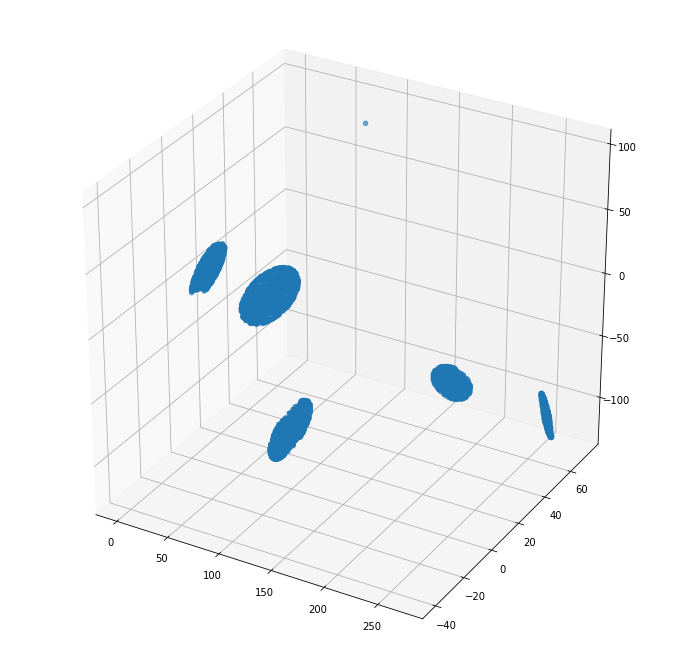

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')


ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2])
_ = plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

gmm = GaussianMixture(n_components=k, covariance_type='diag',
                              random_state=0, n_init=32, max_iter=1000)
gmm.fit(vectors)

GaussianMixture(covariance_type='diag', max_iter=1000, n_components=5,
                n_init=32, random_state=0)

In [ ]:
gmm.means_

array([[  11.66955145,    6.75698894,   11.14450905,   11.59608029],
       [ 196.33923549,   42.62536322,  -72.14792558,  -56.31330819],
       [  73.64962551,    5.42912549,    4.2523544 ,  -61.36074799],
       [ 259.23052211,   66.07363254, -107.3363683 , -116.75361823],
       [ 135.40836753,  -25.59673495,  -56.85852803,  -33.06684681]])

In [ ]:
def top_k_outliers(vectors, k):
  scores = gmm.score_samples(vectors)
  top_k = np.argpartition(-scores, -k)[-k:]
  return top_k, scores[top_k]

In [ ]:
outlier_ind, _ = top_k_outliers(vectors, p)

In [ ]:
labels = gmm.predict(vectors)
labels[outlier_ind] = -1

In [ ]:
from numba import njit, jit

@jit
def noisy_center_radius(points, k):
  dist_matrix = np.zeros((points.shape[0], points.shape[0]))
  for i in range(points.shape[0]):
    for j in range(i):
      dist = np.linalg.norm(points[i] - points[j])
      dist_matrix[i, j] = dist
  dist_matrix = dist_matrix.reshape(-1)
  top_k_dist = np.argsort(dist_matrix)[-k:]
  rows = top_k_dist // points.shape[0]
  cols = top_k_dist % points.shape[0]
  center = 0.5*(points[cols] + points[rows]).mean(axis=0)
  radius = np.ceil(dist_matrix[top_k_dist].mean()/2)
  return center, radius

def center_radius(points):
  dist = torch.cdist(points, points)
  ind = dist.argmax()
  row = (torch.div(ind, points.size(0), rounding_mode='floor')).item()
  col = (ind % points.size(0)).item()
  radius = torch.ceil((dist[row, col]/2)).item()
  center = 0.5 * (points[row] + points[col])
  return center, radius


manifold_center = []
manifold_radius = []

for sphere in range(k):
  points = torch.from_numpy(vectors[labels==sphere])
  # points = vectors[labels==sphere]
  center, radius = center_radius(points)
  manifold_center.append(center)
  manifold_radius.append(radius)

manifold_center = np.vstack(manifold_center)

In [ ]:
manifold_radius

[16.0, 16.0, 16.0, 16.0, 16.0]

In [ ]:
manifold_center

array([[  11.90494827,    6.17724448,   10.43188762,   11.90929491],
       [ 196.99091314,   42.71360611,  -71.92150871,  -56.80364712],
       [  73.5843565 ,    5.00963626,    4.93969297,  -61.43246299],
       [ 258.72480679,   66.31108571, -107.06585946, -116.89128032],
       [ 135.2979448 ,  -25.05564655,  -55.88328262,  -33.1112449 ]])

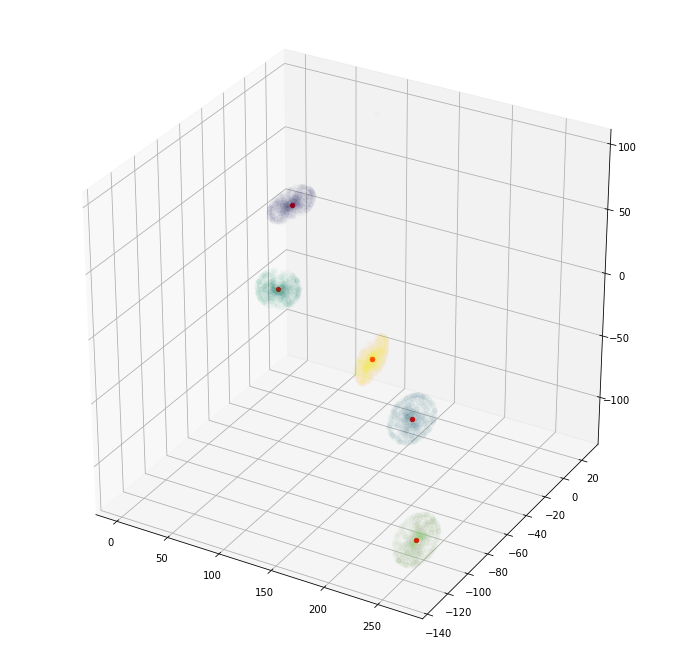

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

# t_colors = (S.flatten().abs() < 0.1).numpy() * 1
# ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c=t_colors)
ax.scatter(vectors[:, 0], vectors[:, 3], vectors[:, 2], c=labels, alpha=0.01)
for sphere in range(k):
  ax.scatter(manifold_center[sphere, 0], manifold_center[sphere, 3], manifold_center[sphere, 2], c='red')

_ = plt.show()

In [ ]:
import skdim.id as intd

manifold_dims = []

for shpere in tqdm(range(k)):
  lpca = intd.lPCA().fit_pw(vectors[labels==sphere], n_neighbors = 64, n_jobs = 1)
  manifold_dims.append(int(np.round(lpca.dimension_pw_.mean())))
  

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
manifold_dims

[3, 3, 3, 3, 3]

In [ ]:
from numba import njit

@njit
def get_best_fitting_plane_vector(centered):

    # Calculate the covariance matrix of the coordinates
    covariance_matrix = np.cov(centered, rowvar=False) # Variables = columns

    # Calculate the eigenvalues & eigenvectors of the covariance matrix
    e_val, e_vect = np.linalg.eig(covariance_matrix)

    # The normal vector to the plane is the eigenvector associated to the minimum eigenvalue
    min_eval = np.argmin(e_val)
    normal_vector = e_vect[:, min_eval]

    return normal_vector

In [ ]:
affine_a = []
affine_b = []

for sphere in tqdm(range(k)):
  points = vectors[labels==sphere]
  shift = points.mean(axis=0)
  centered = points - shift
  a = get_best_fitting_plane_vector(centered)
  b = a @ shift
  affine_a.append(a)
  affine_b.append(b)


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
affine_a

[array([-0.59343816, -0.5850092 ,  0.39159113,  0.39019454]),
 array([ 0.05956588, -0.96215908, -0.19286432, -0.18304416]),
 array([ 0.34988921, -0.00185061, -0.06540776, -0.93450304]),
 array([0.46700006, 0.87703194, 0.11159501, 0.01650683]),
 array([-9.77284346e-01, -2.04150470e-01,  2.32544129e-05, -5.69024777e-02])]

In [ ]:
affine_b

[-1.946618913021454,
 -5.094677945725145,
 82.82283112339093,
 165.103920545361,
 -125.22662914676462]

In [ ]:
with open('output_gmm_n.txt', 'w+') as fp:
  fp.write(f'{n} {k}\n')
  for sphere in range(k):
    fp.write(f'{manifold_dims[sphere]} {K[sphere]} Sphere\n')
    fp.write(' '.join(affine_a[0].astype(str).tolist()) + '\n')
    fp.write(f'{affine_b[0]}\n')
    vec_ind = np.where(labels == sphere)[0]
    fp.write(' '.join(manifold_center[0, :].astype(str).tolist()) + f' {manifold_radius[sphere]} \n')
    fp.write(f'{len(vec_ind)} ')
    fp.write(' '.join((vec_ind+1).astype(str).tolist()))
    fp.write('\n')
  fp.write(f'{p}')
  fp.write(' ' + ' '.join((outlier_ind+1).astype(str).tolist()))